# <center> webscraping

### première partie du projet bloc 1

- Webscraping du site [www.allocine.fr](https://www.allocine.fr/films/)

![filtres](images/filtresSMALL.png)

## Sources :
**Beautiful Soup** :
[beautiful-soup-4](https://beautiful-soup-4.readthedocs.io/en/latest/)<br>
[beautiful-soup-4.readthedocs.io](https://beautiful-soup-4.readthedocs.io/en/latest/#searching-the-tree)<br>

**Selenium** :<br>
[selenium-python.readthedocs.io](https://selenium-python.readthedocs.io/locating-elements.html)<br>
[selenium.dev/documentation](https://www.selenium.dev/documentation/webdriver/elements/information/)<br>
[selenium.dev/documentation/finders/](https://www.selenium.dev/documentation/webdriver/elements/finders/)<br>
[geeksforgeeks.org/get_property-selenium/](https://www.geeksforgeeks.org/get_property-element-method-selenium-python/)<br>

Les liens sont sûrement générés aléatoirement dynamiquement, on peut utiliser XPath avec selenium<br>
ou bien avec lxml ??<br>

In [16]:
%reset

In [2]:
import os
# import re
import io
import copy
import httpx
import requests
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from IPython.display import display
from tqdm import tqdm

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

driver = webdriver.Chrome(options = options)

%config IPCompleter.greedy = True

url_site = 'https://www.allocine.fr/'
url_films = 'https://www.allocine.fr/films/'

### On scrape tous les genres de film

In [3]:
# Scrap all categories
r = requests.get(url_films, auth=('user', 'pass'))
if r.status_code != 200:
    print("url_site error")
    
soup = BeautifulSoup(r.content, 'html.parser')
print(type(soup))

categories = []
elt_categories = soup.find('div', class_='filter-entity-section')
for elt in elt_categories.find_all('li'):
    #print(elt.prettify())
    categories.append(elt.a.text)

print("Nb categories :", len(categories))
df_categories = pd.Series(categories)

dict_n_cat = {k:v for k, v in enumerate(categories)}
dict_cat_n = {v:k for v, k in dict_n_cat.items()}

<class 'bs4.BeautifulSoup'>
Nb categories : 37


### On scrape les pays

In [15]:
elt_countries = elt_categories.find_next_sibling().find_next_sibling()
elts_items = elt_countries.find_all('li', class_ = 'filter-entity-item')

countries = []
for elt_item in elts_items:
    countries.append(elt_item.find('span').text.strip())

print(countries)

print("Nb pays :", len(countries))
df_countries = pd.Series(countries)

dict_n_countries = {k:v for k, v in enumerate(countries)}
dict_countries_n = {v:k for v, k in dict_n_countries.items()}

['France', 'U.S.A.', 'Afrique du Sud', 'Albanie', 'Algérie', 'Allemagne', "Allemagne de l'Est", "Allemagne de l'Ouest", 'Arabie Saoudite', 'Argentine', 'Arménie', 'Australie', 'Autriche', 'Belgique', 'Bengladesh', 'Bolivie', 'Bosnie-Herzégovine', 'Brésil', 'Bulgarie', 'Burkina Faso', 'Cambodge', 'Cameroun', 'Canada', 'Chili', 'Chine', 'Chypre', 'Colombie', 'Corée', 'Corée du Sud', 'Croatie', 'Cuba', "Côte-d'Ivoire", 'Danemark', 'Egypte', 'Emirats Arabes Unis', 'Espagne', 'Estonie', 'Finlande', 'Grande-Bretagne', 'Grèce', 'Géorgie', 'Hong-Kong', 'Hongrie', 'Inde', 'Indonésie', 'Irak', 'Iran', 'Irlande', 'Islande', 'Israël', 'Italie', 'Japon', 'Jordanie', 'kazakhstan', 'Kenya', 'Kosovo', 'Lettonie', 'Liban', 'Lituanie', 'Luxembourg', 'Macédoine', 'Malaisie', 'Maroc', 'Mexique', 'Monténégro', 'Nigéria', 'Norvège', 'Nouvelle-Zélande', 'Pakistan', 'Palestine', 'Pays-Bas', 'Philippines', 'Pologne', 'Portugal', 'Pérou', 'Qatar', 'Roumanie', 'Russie', 'République dominicaine', 'République tchè

### On scrape les films par période
[1980 - 1989] puis [1990 - 1999] ...

In [22]:
# Scrap url of years we want to scrap the movies
# Not Working
# I cannot get the url by scraping
decades_to_scrap = list([str(item) for item in range(1980, 2020, 10)])
decades_to_scrap = list([str(item) for item in range(1980, 1989, 10)])
print(decades_to_scrap)
elt_years = elt_categories.find_next_sibling()
#print(eltYears.prettify())
lstUrl = []
elt_cur = elt_years.find('li')

while elt_cur:
    text = elt_cur.span.text
    #print(elt_cur)
    #print(elt_cur.span.get('href')) # NOT WORKING because url are 'decorated'
    if text[:4] in decades_to_scrap:
        print("**", text)
    else:
        print(elt_cur.span.text)
    elt_cur = elt_cur.find_next_sibling()

['1980']
2030 - 2039
2020 - 2029
2010 - 2019
2000 - 2009
1990 - 1999
** 1980 - 1989
1970 - 1979
1960 - 1969
1950 - 1959
1940 - 1949
1930 - 1939
1920 - 1929
1910 - 1919
1900 - 1909
1890 - 1899


### Autre méthode utilisant Selenium
Puisque nous n'arrivons pas à récupérer les urls nous allons utiliser Selenium qui permet entre autre :
- d'utiliser les XPath (contrairement à Beautiful Soup)
- de récupérer certains élements 'décorés' par exemple des urls

decade: https://www.allocine.fr/films/decennie-1980/
year: https://www.allocine.fr/films/decennie-1980/annee-1980/
Title: La Boum
Date: 17 décembre 1980
Duration: 1h 49min
Categories: Comédie,Drame,Romance
Directors: ['Claude Pinoteau']
Actors: ['Sophie Marceau', 'Brigitte Fossey', 'Claude Brasseur', 'Denise Grey', "Sheila O'Connor", 'Bernard Giraudeau', 'Dominique Lavanant', 'Jean-Pierre Castaldi']
Summary: Vic vit tranquillement entre le lycée, ses parents et Poupette, son arrière-grand-mère. Lorsque sa mère apprend l'existence d'une ancienne maîtresse de son mari, elle décide de "faire un break" mais du haut de ses 13 ans Vic ne pense qu'à sa première boum...
Thumbnail: https://fr.web.img3.acsta.net/c_310_420/medias/nmedia/18/62/90/68/18658418.jpg
La Boum


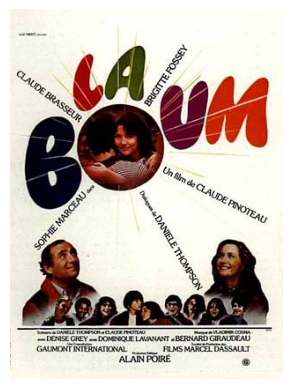

Title: Shining
Date: 16 octobre 1980
Duration: 2h 23min
Categories: Epouvante-horreur,Thriller
Directors: ['Stanley Kubrick']
Actors: ['Jack Nicholson', 'Shelley Duvall', 'Danny Lloyd', 'Scatman Crothers', 'Barry Nelson', 'Philip Stone', 'Joe Turkel', 'Anne Jackson']
Summary: Écrivain, Jack Torrance est engagé comme gardien, pendant tout l’hiver, d’un grand hôtel isolé du Colorado – l’Overlook – où il espère surmonter enfin sa panne d’inspiration. Il s’y installe avec sa femme Wendy et son fils Danny, doté d’un don de médium. Tandis que Jack n’avance pas dans son livre et que son fils est de plus en plus hanté par des visions terrifiantes, il découvre les terribles secrets de l’hôtel et bascule peu à peu dans une forme de folie meurtrière où il s’en prend à sa propre famille…
Thumbnail: https://fr.web.img3.acsta.net/c_310_420/pictures/19/09/24/09/25/3228359.jpg
Shining


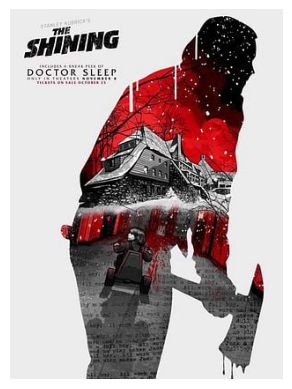

Title: Star Wars : Episode V - L'Empire contre-attaque
Date: 20 août 1980
Duration: 2h 04min
Categories: Aventure,Science Fiction
Directors: ['Irvin Kershner']
Actors: ['Mark Hamill', 'Harrison Ford', 'Carrie Fisher', 'David Prowse', 'Anthony Daniels', 'Kenny Baker', 'Peter Mayhew', 'Frank Oz']
Summary: Malgré la destruction de l'Etoile Noire, l'Empire maintient son emprise sur la galaxie, et poursuit sans relâche sa lutte contre l'Alliance rebelle. Basés sur la planète glacée de Hoth, les rebelles essuient un assaut des troupes impériales. Parvenus à s'échapper, la princesse Leia, Han Solo, Chewbacca et C-3P0 se dirigent vers Bespin, la cité des nuages gouvernée par Lando Calrissian, ancien compagnon de Han. Suivant les instructions d'Obi-Wan Kenobi, Luke Skywalker se rend quant à lui vers le système de Dagobah, planète marécageuse où il doit recevoir l'enseignement du dernier maître Jedi, Yoda. Apprenant l'arrestation de ses compagnons par les stormtroopers de Dark Vador après la tra

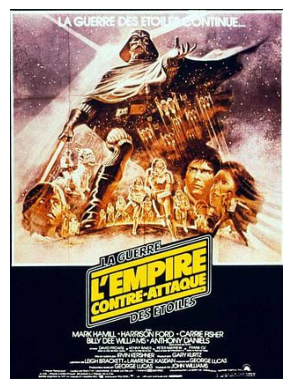

Title: Elephant Man
Date: 8 avril 1981
Duration: 2h 05min
Categories: Biopic,Drame
Directors: ['David Lynch']
Actors: ['Anthony Hopkins', 'John Hurt', 'Anne Bancroft', 'John Gielgud', 'Wendy Hiller', 'Freddie Jones', 'Hannah Gordon', 'Michael Elphick']
Summary: Londres, 1884. Le chirurgien Frederick Treves découvre un homme complètement défiguré et difforme, devenu une attraction de foire. John Merrick, " le monstre ", doit son nom de Elephant Man au terrible accident que subit sa mère. Alors enceinte de quelques mois, elle est renversée par un éléphant. Impressionné par de telles difformités, le Dr. Treves achète Merrick, l'arrachant ainsi à la violence de son propriétaire, et à l'humiliation quotidienne d'être mis en spectacle. Le chirurgien pense alors que " le monstre " est un idiot congénital. Il découvre rapidement en Merrick un homme meurtri, intelligent et doté d'une grande sensibilité.
Thumbnail: https://fr.web.img4.acsta.net/c_310_420/pictures/20/02/21/16/48/4302324.jpg
Eleph

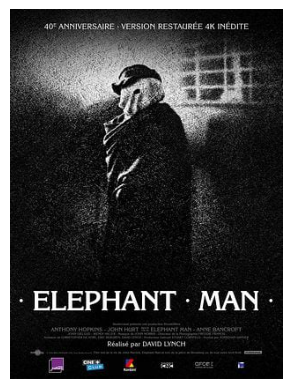

Title: Y a-t-il un pilote dans l'avion ?
Date: 24 septembre 1980
Duration: 1h 25min
Categories: Comédie
Directors: ['David Zucker', 'Jim Abrahams', 'Jerry Zucker']
Actors: ['Kareem Abdul-Jabbar', 'Leslie Nielsen', 'Peter Graves', 'Julie Hagerty', 'Robert Stack', 'Lloyd Bridges', 'Robert Hays', 'Jonathan Banks']
Summary: Le vol 209, à destination de Chicago n'est pas vraiment un vol ordinaire. Tous les membres de l'équipage étant victimes d'un empoisonnement alimentaire, il faut vite trouver un pilote de dépannage parmi les passagers. Elaine supplie son ex-ami, un ancien pilote de chasse de prendre les commandes de l'avion.
Thumbnail: https://fr.web.img6.acsta.net/c_310_420/pictures/18/11/13/09/27/0465647.jpg
Y atil un pilote dans l'avion ?
Cannot read the file
Title: Cannibal Holocaust
Date: 22 avril 1981
Duration: 1h 26min
Categories: Epouvante-horreur
Directors: ['Ruggero Deodato']
Actors: ['Robert Kerman', 'Francesca Ciardi', 'Perry Pirkanen', 'Luca Barbareschi', 'Salvatore Basile',

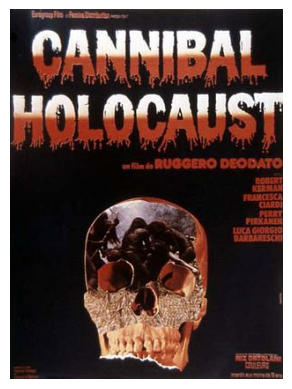

Title: Les Sous-doués
Date: 30 avril 1980
Duration: 1h 32min
Categories: Comédie
Directors: ['Claude Zidi']
Actors: ['Daniel Auteuil', 'Maria Pacôme', 'Michel Galabru', 'Hubert Deschamps', 'Tonie Marshall', 'Féodor Atkine', 'Philippe Taccini', 'Raymond Bussières']
Summary: Bébel et ses petits camarades du Cours Louis XIV, sont réputés pour être des fainéants et d'invétérés farceurs. Leur lycée est même dernier du classement au baccalauréat avec 100% de recalés à l'examen! Après une plaisanterie qui tourne mal, les trublions se retrouvent obligés d'obtenir leur bac à tout prix, tout en rusant et trichant, s'ils ne veulent pas finir en prison...
Thumbnail: https://fr.web.img6.acsta.net/c_310_420/medias/nmedia/18/66/58/65/19721206.jpg
Les Sousdoués


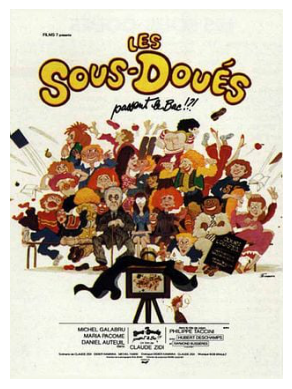

Title: Fog
Date: 19 mars 1980
Duration: 1h 29min
Categories: Epouvante-horreur
Directors: ['John Carpenter']
Actors: ['Adrienne Barbeau', 'Jamie Lee Curtis', 'Janet Leigh', 'John Houseman', 'Tom Atkins', 'James Canning', 'Charles Cyphers', 'Hal Holbrook']
Summary: En Californie, le port d’Antonio Bay fête son centenaire. La légende raconte que les marins d’un navire naufragé un siècle auparavant, reviendront se venger par une nuit de brouillard. Le Révérend Malone découvre le journal de son ancêtre qui explique que le navire avait été coulé par six membres fondateurs de la ville. Pour expier leurs fautes, six victimes doivent périr. Or, une brume maléfique commence à semer la terreur et la mort sur son passage...
Thumbnail: https://fr.web.img3.acsta.net/c_310_420/pictures/18/09/24/16/27/0018981.jpg
Fog


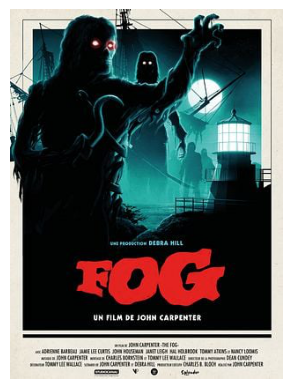

Title: American Gigolo
Date: 9 juin 1980
Duration: 2h 00min
Categories: Drame
Directors: ['Paul Schrader']
Actors: ['Richard Gere', 'Lauren Hutton', 'Hector Elizondo', 'Bill Duke', 'Nina Van Pallandt', 'K Callan', 'Brian Davies', 'Tom Stewart']
Summary: Julian Kay, un beau ténébreux trentenaire, loue ses charmes à des femmes dans le besoin. Après avoir passé la nuit avec l'épouse d'un homme d'affaires, cette dernière est retrouvée morte et les soupçons de la police se portent naturellement sur Julian. Le meurtre semble être un coup monté de toute pièce pour l'incriminer et Julian est bien décidé à le prouver.
Thumbnail: https://fr.web.img3.acsta.net/c_310_420/medias/nmedia/18/65/85/34/18893453.jpg
American Gigolo


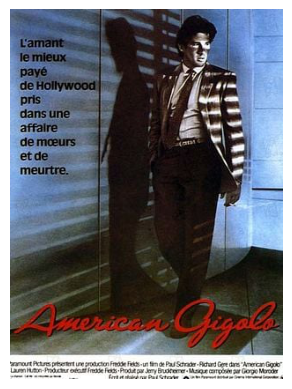

Title: Raging Bull
Date: 25 mars 1981
Duration: 2h 09min
Categories: Biopic,Drame,Évènement Sportif
Directors: ['Martin Scorsese']
Actors: ['Robert De Niro', 'Cathy Moriarty', 'Joe Pesci', 'Frank Vincent', 'Nicholas Colasanto', 'Theresa Saldana', 'Charles Scorsese', 'Martin Scorsese']
Summary: Raging Bull retrace les moments forts de la carrière flamboyante de Jake La Motta, champion de boxe poids moyen. Issu d'un milieu modeste, il fut le héros de combats mythiques, notamment contre Robinson et Cerdan. Autodestructeur, paranoïaque, déchiré entre le désir du salut personnel et la damnation, il termine son existence, bouffi, en tant que gérant de boîte de nuit et entertainer. Quand l'ascension et le déclin d'une vie deviennent épopée...
Thumbnail: https://fr.web.img4.acsta.net/c_310_420/pictures/23/02/28/15/18/0776073.jpg
Raging Bull


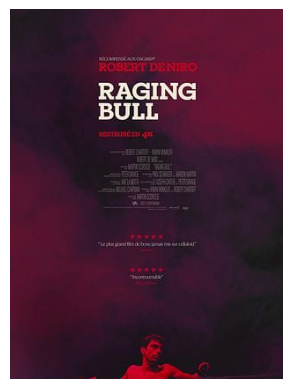

Title: Le Roi et l'oiseau
Date: 19 mars 1980
Duration: 1h 27min
Categories: Animation
Directors: ['Paul Grimault', 'Jacques Prévert']
Actors: []
Summary: Le Roi Charles V et Trois font Huit et Huit font Seize règne en tyran sur le royaume de Takicardie. Seul un Oiseau, enjoué et bavard, qui a construit son nid en haut du gigantesque palais, tout près des appartements secrets de Sa Majesté, ose le narguer. Le Roi est amoureux d’une charmante et modeste Bergère qu’il veut épouser sous la contrainte. Mais celle-ci aime un petit Ramoneur. Tous deux s’enfuient pour échapper au Roi...
Thumbnail: https://fr.web.img3.acsta.net/c_310_420/pictures/210/095/21009544_20130530152117763.jpg
Le Roi et l'oiseau


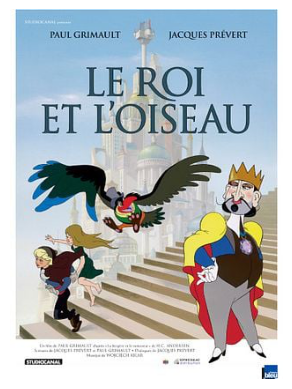

Title: Le Dernier métro
Date: 17 septembre 1980
Duration: 2h 13min
Categories: Drame,Romance,Guerre
Directors: ['François Truffaut']
Actors: ['Catherine Deneuve', 'Gérard Depardieu', 'Jean Poiret', 'Heinz Bennent', 'Laszlo Szabo (I)', 'Andréa Ferréol', 'Jean-Louis Richard', 'Maurice Risch']
Summary: Paris, septembre 1942. Lucas Steiner, le directeur du théâtre Montmartre a dû fuir parce qu’il est juif. Sa femme Marion Steiner dirige le théâtre et engage Bernard Granger, transfuge du Grand Guignol, pour jouer à ses côtés dans « la Disparue », que met en scène Jean-Louis Cottins. Jusqu’au soir de la générale, la troupe subit les menaces du virulent critique de « Je suis partout », Daxiat, dont l’ambition est de diriger la Comédie-Française. Et si, par amour pour sa femme, Lucas Steiner avait fait semblant de fuir la France et était resté caché dans la cave de son théâtre pendant toute la guerre….
Thumbnail: https://fr.web.img6.acsta.net/c_310_420/pictures/14/07/25/15/42/369952.jpg
Le Der

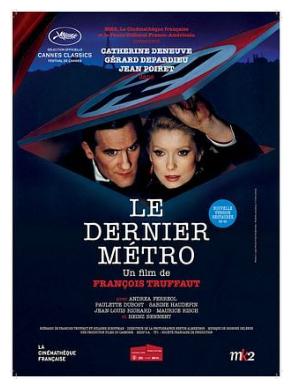

Title: The Blues Brothers
Date: 7 novembre 1980
Duration: 2h 29min
Categories: Comédie,Musical
Directors: ['John Landis']
Actors: ['John Belushi', 'Dan Aykroyd', 'James Brown', 'Cab Calloway', 'Carrie Fisher', 'Henry Gibson', 'John Lee Hooker', 'Aretha Franklin']
Summary: Dès sa sortie de prison, Jake Blues est emmené par son frère Elwood chez Soeur Mary Stigmata, qui dirige l'orphelinat dans lequel ils ont été élevés. Ils doivent réunir 5 000 dollars pour sauver l'établissement, sinon c'est l'expulsion.
Thumbnail: https://fr.web.img4.acsta.net/c_310_420/medias/nmedia/00/00/00/81/379_af.jpg
The Blues Brothers


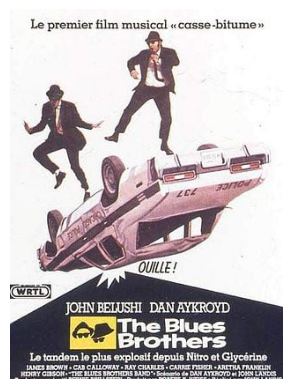

Title: Pulsions
Date: 15 avril 1981
Duration: 1h 46min
Categories: Epouvante-horreur,Thriller
Directors: ['Brian De Palma']
Actors: ['Michael Caine', 'Angie Dickinson', 'Nancy Allen', 'Keith Gordon', 'Dennis Franz', 'David Margulies', 'Brandon Maggart', 'Mary Davenport']
Summary: Kate Miller souffre de fantasmes érotiques si vivaces qu’elle a du mal à faire la part du rêve et de la réalité. Un matin, elle se rend chez son psychiatre, Robert Elliot, pour lui parler de ses déceptions sexuelles avec son mari. En se rendant au musée, Kate séduit un homme qui l’emmène dans son appartement pour y passer la nuit. Le lendemain matin, en prenant l’ascenseur pour quitter l’immeuble, Kate est atrocement assassinée à coups de rasoir par une femme blonde portant de grosses lunettes noires.
Thumbnail: https://fr.web.img6.acsta.net/c_310_420/medias/nmedia/18/35/91/04/20183103.jpg
Pulsions


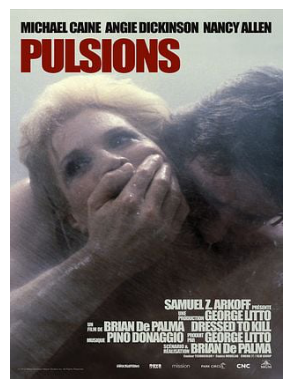

Title: La Porte du paradis
Date: 22 mai 1981
Duration: 3h 39min
Categories: Aventure,Drame,Western
Directors: ['Michael Cimino']
Actors: ['Kris Kristofferson', 'Christopher Walken', 'John Hurt', 'Isabelle Huppert', 'Sam Waterston', 'Brad Dourif', 'Joseph Cotten', 'Jeff Bridges']
Summary: Deux anciens élèves de Harvard se retrouvent en 1890 dans le Wyoming. Averill est shérif fédéral tandis que Billy Irvine, rongé par l'alcool, est membre d'une association de gros éleveurs en lutte contre les petits immigrants venus pour la plupart d'Europe centrale. Averill s'oppose à l'intervention de l'association sur le district et tente de convaincre son amie Ella, une prostituée d'origine française, de quitter le pays.
Thumbnail: https://fr.web.img4.acsta.net/c_310_420/medias/nmedia/18/35/24/23/20477367.jpg
La Porte du paradis


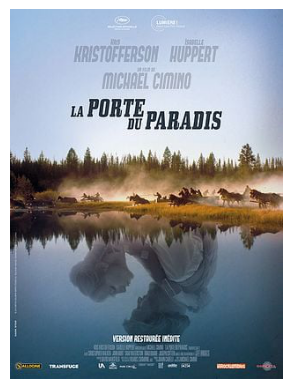

In [56]:
def number_pages_per_year(soup_year):
    ''' Return the number of pages for one year'''
    pagination = soup_year.find('div', class_='pagination-item-holder')
    nb_pages = int(pagination.find_all('span')[-1].text)
    return int(nb_pages)

def get_title(soup_movie):
    return soup_movie.find('div', class_ = "titlebar-title titlebar-title-xl").text

def get_date_duration_categories(soup_movie):
    elt = soup_movie.find('div', class_="meta-body-item meta-body-info")
    text = elt.get_text(strip=True)
    s1, s2, s3 = text.split('|')
    date = s1[:-8].strip()
    duration = s2.strip()
    categories = s3.strip()
    return date, duration, categories

def get_directors(soup_casting):
    elt_director_section = soup_casting.find('section', class_='section casting-director')
    elt_temp = elt_director_section.find_next()
    # print(elt_temp.prettify())
    elts_directors = elt_temp.find_next_sibling().find_all('div', class_ = 'card person-card person-card-col')
    lst_directors = [elt_director.find('a').text for elt_director in elts_directors]
    return lst_directors

def get_actors(soup_casting):
    elt_actor_section = soup_casting.find('section', class_ = 'section casting-actor')
    if not(elt_actor_section):
        return []
    elt_temp = elt_actor_section.find_next()
    #print(elt_temp.prettify())
    elts_actors = elt_temp.find_next_sibling().find_all('div', class_ = 'card person-card person-card-col')
    lst_actors = [elt_actor.find('figure').find('span')['title'] for elt_actor in elts_actors]
    elts_actors = elt_actor_section.find_all('div', class_ = 'md-table-row')
    #print('Actors:', elts_actors)
    # We complete the actor list to get 10 actors
    nb_complete = 10 - len(lst_actors)
    #lst_actors.extend([elt_actor.find('a').text for elt_actor in elts_actors[:nb_complete] if elt_actor.find('a')])
    return lst_actors

def get_summary(soup_movie):
    elt = soup_movie.find('section', class_ = "section ovw ovw-synopsis")
    return elt.find('p', class_ = 'bo-p').text.strip()

def get_thumbnail(soup_movie):
    elt = soup_movie.find('figure', class_ = 'thumbnail')
    return elt.span.img['src']

def scrap_movie(elt_movie):
    ''' scrap all movie informations '''
    # get soup
    url_movie = url_site + elt_movie.h2.a.get('href')
    r = requests.get(url_movie, auth=('user', 'pass'))
    soup_movie = BeautifulSoup(r.content, 'html.parser')

    # Get title
    title = get_title(soup_movie)
    print("Title:" , get_title(soup_movie))

    # Get date, duration and categories
    date, duration, categories = get_date_duration_categories(soup_movie)
    print("Date:", date)
    print("Duration:", duration)
    print("Categories:", categories)

    # Get directors / Actors
    lst_directors, lst_actors = [], []
    elt_link_casting = soup_movie.find('a', class_ = 'end-section-link')

    if elt_link_casting and 'Casting' in elt_link_casting['title']:
        link_casting = elt_link_casting['href']
        r = requests.get(url_site + link_casting, auth=('user', 'pass'))
        soup_casting = BeautifulSoup(r.content, 'html.parser')
        # Get directors' list
        lst_directors = get_directors(soup_casting)
        # Get actors' list
        lst_actors = get_actors(soup_casting)

    else: # Animation Case Only ???
        # print(elt_link_casting.prettify())
        elts = soup_movie.find_all('div', class_ = "meta-body-item meta-body-direction meta-body-oneline")
        # Get directors' list
        lst_directors = [elts[0].text.strip()[2:].strip()]

        if len(elts) > 1:
            elts_span = elts[1].find_all('span')
            for elt in elts_span:
                if 'light' in elt['class']:
                    continue
                if elt.get_text(strip=True) not in lst_directors:
                    lst_directors.append(elt.get_text(strip=True))

        # Get actors' list (Not for animation movie)
        # elt = soup_movie.find('div', class_ = "meta-body-item meta-body-actor")
        # lst_actors = elt.get_text(strip=True)[4:]

    print('Directors:', lst_directors)
    print('Actors:', lst_actors)

    # Get summary
    print("Summary:", get_summary(soup_movie))

    # Get thumbnail url
    url_thumbnail = get_thumbnail(soup_movie)
    print("Thumbnail:", url_thumbnail)

    # Save the image
    try:
        folder_name = os.getcwd() + '\\thumbnails\\'
        title2 = title.replace('-', '')
        print(title2)
        image_name = f"thumbnail-{title2}.jpg"
        file = open(folder_name + image_name, "wb")
        image = httpx.get(url_thumbnail)
        file.write(image.content)
        img = Image.open(io.BytesIO(image.content))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        # To change resolution: https://www.geeksforgeeks.org/change-image-resolution-using-pillow-in-python/
    except IOError:
        print("Cannot read the file")
    # finally:
    #     file.close()

    return

    # Get ratings


# ----------------- #
#       Main        #
# ----------------- #

# Delete all files in thumbnail directory
# try:
#     folder_name = os.getcwd() + '\\thumbnails\\'
#     files = os.listdir(folder_name)
#     for file in files:
#         file_path = os.path.join(folder_name, file)
#         if os.path.isfile(file_path):
#             os.remove(file_path)
#     print("All files deleted successfully.")
# except OSError:
#     print("Error occurred while deleting files.")


driver.get(url_films)
elts_decades = driver.find_elements(By.XPATH, '/html/body/div[2]/main/section[3]/div[1]/div/div[3]/div[2]/ul/li')

for elt_decade in elts_decades:
    elt_a = elt_decade.find_element(By.TAG_NAME, 'a')

    if elt_a.get_attribute('title')[:4] in decades_to_scrap:
        url_decades = elt_a.get_attribute('href')
        print("decade:", url_decades)
        driver2 = webdriver.Chrome(options = options)
        driver2.get(url_decades)

        elts_years = driver2.find_elements(By.XPATH, '/html/body/div[2]/main/section[3]/div[1]/div/div[3]/div[3]/ul/li')
        #print(len(elts_years))
        
        for elt_year in elts_years[::-1]:
            elt_a_year = elt_year.find_element(By.TAG_NAME, 'a')

            url_year = elt_a_year.get_attribute('href')
            print("year:", url_year)

            r = requests.get(url_year, auth=('user', 'pass'))
            if r.status_code != 200:
                print("url_site error")

            # We get the number of pages for this year
            soup_year = BeautifulSoup(r.content, 'html.parser')
            nb_pages = number_pages_per_year(soup_year)
            # print('Nb pages:', nb_pages)

            for i in range(nb_pages): # Need to reduce as some movies are totaly unknown with very few informations about
                url_year_page = url_year + f'?page={i+1}'
                # print(url_year_page)
                r = requests.get(url_year_page, auth=('user', 'pass'))
                if r.status_code != 200:
                    print("url_site error")
                soup_movies = BeautifulSoup(r.content, 'html.parser')
                elt_movies = soup_movies.find_all('li', class_='mdl')
                for elt_movie in elt_movies:
                    scrap_movie(elt_movie)
                break
            break

### Ou bien nous pouvons entrer les url manuellement

In [4]:
url_decades = url_films + 'decennie-1980/'
url_year = url_films + 'decennie-1980/annee-1980/'

def getNumberOfPages(elt):
    nb = 0
    while elt:
        if elt.text.isdigit():
            nb = elt.text
        elt = elt.find_next_sibling()
    return int(nb)

r = requests.get(url_year, auth=('user', 'pass'))
if r.status_code != 200:
    print("url_site error")

# We get the number of pages for this year
soup = BeautifulSoup(r.content, 'html.parser')
pagination = soup.find('div', class_='pagination-item-holder')
nb_pages = int(pagination.find_all('span')[-1].text)
assert nb_pages == getNumberOfPages(pagination.find('span'))
print(nb_pages)

47


### On scrape chaque page de films pour une année donnée

In [1]:
def scrapMoviePage(url_movie):
    # get soup from movie page
    r = requests.get(url_movie, auth=('user', 'pass'))
    soupMovie = BeautifulSoup(r.content, 'html.parser')
    print("Title:" , soupMovie.find('div', class_ = "titlebar-title titlebar-title-xl").text)
    
    elt = soupMovie.find('div', class_="meta-body-item meta-body-info")
    text = elt.get_text(strip=True)

    s1, s2, s3 = text.split('|')
    date = s1[:-8].strip()
    print("Date:", date)
    duration = s2.strip()
    print("Duration:", duration)
    categories = s3.strip()
    print("Categories:", categories)

    elts = soupMovie.find_all('div', class_ = "meta-body-item meta-body-direction meta-body-oneline")
    #assert len(elts)
    authors = [elts[0].text.strip()[2:].strip()]

    if len(elts) > 1:
        elts_span = elts[1].find_all('span')
        for elt in elts_span:
            if 'light' in elt['class']:
                continue
            if elt.get_text(strip=True) not in authors:
                authors.append(elt.get_text(strip=True))
    authors = ', '.join(authors)
    print("Authors:", authors)

    elt = soupMovie.find('div', class_ = "meta-body-item meta-body-actor")
    actors = elt.get_text(strip=True)[4:]
    print("Actors:", actors)

    elt = soupMovie.find('section', class_ = "section ovw ovw-synopsis")
    elt2 = elt.find('div', class_ = "content-txt")
    elt3 = elt.find('p', class_ = 'bo-p')
    summary = elt3.text.strip()
    print("Summary:", summary)

    # driver to the movie page
    driver.get(url_movie)
    elts_rating = driver.find_elements(By.CLASS_NAME, 'rating-item')
    print(len(elts))
    for elt in elts:
        #print(elt.text)
        elt_a = elt.find_element(By.TAG_NAME, 'a')
        print(elt_a.get_attribute('href'))

    return
    # beautiful soup version
    elts_rating = soupMovie.find_all('div', class_ = 'rating-item')
    #print(len(elts_rating))
    ratings = {}

    for elt_rating in elts_rating:
        print(elt_rating.prettify())
        elt_temp = elt_rating.find('div', class_='rating-item-content')
        elt_span = elt_temp.find('span')
        print("span class", elt_span['class'])
        if 'rating-title' in elt_span['class']:
            print('rating-title')
            print(elt_span.get_text(strip = True))
            if 'Spectateurs' in elt_span.get_text(strip = True):
                ratings['spectateurs'] = elt_temp.find('span', class_ = 'stareval-note').text
        #     # print(elt_span.get_text(strip = True))
        # elif 'rating-title' in elt_span['class']:
        #     if 'Presse' in elt_span.get_text(strip = True):
        #         ratings['Presse'] = elt_temp.find('span', class_ = 'stareval-note').text
    print("ratings:", ratings)

movies = []

for i in range(1, 3):
    url_year_page = url_year + '?page=' + str(i)
    r = requests.get(url_year_page, auth=('user', 'pass'))
    if r.status_code != 200:
        print("url_site error")
    soupMovies = BeautifulSoup(r.content, 'html.parser')
    eltMovies = soupMovies.find_all('li', class_='mdl')

    for eltMovie in eltMovies:
        url_movie = url_site + eltMovie.h2.a.get('href')
        scrapMoviePage(url_movie)
    #    print()
    #break

NameError: name 'url_year' is not defined

In [ ]:
driver.close()